# Pittsburgh Real Estate Analysis

## Is Pittsburgh experiencing a real estate bubble?

### Introduction

Pittsburgh Real Estate prices are relatively affordable, the median home price is $150,000. Prices have been steadily increasing over the past five years. If this is just a correction in price from the deflated values caused by the Great Recession, the price will level off. If this is a market bubble, prices may continue to rise until prospective homeowners are unable to afford a house. 

In this project we'll look at the state of Pittsburgh real estate prices. The historic state of prices over the past five years. We'll also look at basic demographics of the city such as population and income-levels.

In [1]:
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import math
import numpy as np

pd.set_option('display.max_columns', None)

### The Data

First, we'll read in the transactional records of all Pittsburgh real estate over the past five years. The CSV file was obtained from [the Allegheny County Information Portal](http://infoportal.alleghenycounty.us/resalesdata/). The original file has many inconsequential columns such as which property deed book the transaction is recorded in. The data must first be cleaned of these columns. 

The data also has a "sale code" column which records if the sale was "valid" in the eyes of the county or not. Invalid sales can be foreclosures in which the property never enters the market or "family and loved ones" sales which are typically priced between one dollar and ten dollars. After removing entries for the invalid sales and keeping only the sales for Pittsburgh city zip codes (rather than suburbs and rural county sales) the sum of null records is 40. These are normalized to the median of the zip code. A couple hundred sales are recorded as $1,000 or less. These are entries which are recorded as "valid" sales, but are most likely tax dodges or family and loved-ones sales. The prices of these entries are normalized to the zip median as well because if the homes are put back on the market, they will probably fetch average prices.

In [2]:
#read the pittsburgh data in as a pandas dataframe
raw_sales_df = pd.read_csv('data/pgh_re_sales.csv', low_memory=False)
raw_forecl_df = pd.read_csv('data/foreclosures.csv', low_memory=False)

In [3]:
raw_sales_df = raw_sales_df.assign(foreclosed=raw_sales_df.PARID.isin(raw_forecl_df.pin))

In [4]:
raw_sales_df[raw_sales_df.foreclosed == True].shape[0]

25774

In [5]:
#create a new dataframe without certain columns
drop_list = [
    "_id", "PARID", "MUNICODE", "DEEDBOOK", "DEEDPAGE", "SALEDESC", "INSTRTYP",
    "INSTRTYPDESC", "PGH_COUNCIL_DISTRICT", "PGH_WARD", "PGH_PUBLIC_WORKS_DIVISION",
    "PGH_POLICE_ZONE", "PGH_FIRE_ZONE", "TRACT", 'RECORDDATE', "BLOCK_GROUP",'SCHOOLCODE', 'SCHOOLDESC', 'MUNICODE',
       'MUNIDESC', 'MUNICIPALITY', 'NEIGHBORHOOD'
            ]
address_cleaning_df = raw_sales_df[[column for column in raw_sales_df.columns if column not in drop_list]]

#### Data Cleaning

The street address is split into several columns in the original dataset. PROPERTYHOUSENUM, PROPERTYFRACTION, PROPERTYADDRESSDIR, PROPERTYADDRESSSTREET, PROPERTYADDRESSUF, PROPERTYADDRESSUNITDESC, and PROPERTYUNITNO all make one address such as: 5022 1/2 S. Penn Ave. Apt. 4. These columns are combined to make one street_address column.

In [6]:
address_cleaning_df.head()

,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,PROPERTYZIP,SALEDATE,PRICE,SALECODE,foreclosed
0,632.0,,NaN,WESTLAND,DR,NaN,NaN,GIBSONIA,PA,15044.0,2015-07-17,232500.0,36,False
1,939.0,,NaN,GREENOCK BUENA VISTA,RD,NaN,NaN,MC KEESPORT,PA,15135.0,2015-07-01,51500.0,36,True
2,3217.0,,NaN,UNIVERSAL,ST,NaN,NaN,PITTSBURGH,PA,15204.0,2015-07-29,9000.0,36,True
3,503.0,,NaN,FRIDAY,RD,NaN,NaN,PITTSBURGH,PA,15209.0,2015-07-31,59000.0,36,False
4,2223.0,,NaN,KINGRIDGE,RD,NaN,NaN,PITTSBURGH,PA,15237.0,2015-07-31,360000.0,36,False


In [7]:
#create a function that creates a column of full addresses by concatenating the partial address columns
def make_full_address(row):
    house_num = str(row['PROPERTYHOUSENUM'])
    fraction = row['PROPERTYFRACTION']
    direction = '' if row['PROPERTYADDRESSDIR'] == 'nan' else row['PROPERTYADDRESSDIR']
    street = row['PROPERTYADDRESSSTREET']
    uf = row['PROPERTYADDRESSSUF']
    unit_desc = '' if row['PROPERTYADDRESSUNITDESC'] == 'nan' else row['PROPERTYADDRESSUNITDESC']
    unit_no = '' if row['PROPERTYUNITNO'] == 'nan' else row['PROPERTYUNITNO']
    return '{} {} {} {} {} {}: {}'.format(house_num, fraction, direction, street, uf, unit_desc, unit_no)

In [8]:
#use the created function to make a street address column
address_cleaning_df = address_cleaning_df.assign(street_address=address_cleaning_df.apply(make_full_address, axis=1))

In [9]:
address_cleaning_df['street_address'].head()

0                632.0   nan WESTLAND DR nan: nan
1    939.0   nan GREENOCK BUENA VISTA RD nan: nan
2              3217.0   nan UNIVERSAL ST nan: nan
3                  503.0   nan FRIDAY RD nan: nan
4              2223.0   nan KINGRIDGE RD nan: nan
Name: street_address, dtype: object

#### Data Cleaning cont.

Many "nan" values and the occasional ":" are leftover. These are stripped out and the previous street address columns (now combined into one) are dropped.

In [10]:
#remove decimal points, null values, commas and extra spaces from the address column
def address_fix(address):
    return address.replace('.0', '', 1).replace('nan', '').replace(':', '').replace('  ', ' ').strip()

In [11]:
address_cleaning_df = address_cleaning_df.assign(street_address=address_cleaning_df['street_address'].apply(address_fix))

In [12]:
address_cleaning_df['street_address'].head()

0                632  WESTLAND DR
1    939  GREENOCK BUENA VISTA RD
2              3217  UNIVERSAL ST
3                  503  FRIDAY RD
4              2223  KINGRIDGE RD
Name: street_address, dtype: object

In [13]:
address_cleaning_df.columns

Index(['PROPERTYHOUSENUM', 'PROPERTYFRACTION', 'PROPERTYADDRESSDIR',
       'PROPERTYADDRESSSTREET', 'PROPERTYADDRESSSUF',
       'PROPERTYADDRESSUNITDESC', 'PROPERTYUNITNO', 'PROPERTYCITY',
       'PROPERTYSTATE', 'PROPERTYZIP', 'SALEDATE', 'PRICE', 'SALECODE',
       'foreclosed', 'street_address'],
      dtype='object')

In [14]:
#remove the partial address columns that were used to create street_address
new_drop = [
    "PROPERTYHOUSENUM", "PROPERTYFRACTION", "PROPERTYADDRESSDIR", "PROPERTYADDRESSSTREET", "PROPERTYADDRESSSUF", "PROPERTYADDRESSUNITDESC", "PROPERTYUNITNO"
            ]
address_clean_df = address_cleaning_df[[column for column in address_cleaning_df.columns if column not in new_drop]]

In [15]:
address_clean_df.head()

,PROPERTYCITY,PROPERTYSTATE,PROPERTYZIP,SALEDATE,PRICE,SALECODE,foreclosed,street_address
0,GIBSONIA,PA,15044.0,2015-07-17,232500.0,36,False,632 WESTLAND DR
1,MC KEESPORT,PA,15135.0,2015-07-01,51500.0,36,True,939 GREENOCK BUENA VISTA RD
2,PITTSBURGH,PA,15204.0,2015-07-29,9000.0,36,True,3217 UNIVERSAL ST
3,PITTSBURGH,PA,15209.0,2015-07-31,59000.0,36,False,503 FRIDAY RD
4,PITTSBURGH,PA,15237.0,2015-07-31,360000.0,36,False,2223 KINGRIDGE RD


In [16]:
#rename the columns
address_clean_df.columns = ['city', 'state', 'zip', 'sale_date', 'price', 'sale_code', 'foreclosed', 'street_address', ]
address_clean_df.head()

,city,state,zip,sale_date,price,sale_code,foreclosed,street_address
0,GIBSONIA,PA,15044.0,2015-07-17,232500.0,36,False,632 WESTLAND DR
1,MC KEESPORT,PA,15135.0,2015-07-01,51500.0,36,True,939 GREENOCK BUENA VISTA RD
2,PITTSBURGH,PA,15204.0,2015-07-29,9000.0,36,True,3217 UNIVERSAL ST
3,PITTSBURGH,PA,15209.0,2015-07-31,59000.0,36,False,503 FRIDAY RD
4,PITTSBURGH,PA,15237.0,2015-07-31,360000.0,36,False,2223 KINGRIDGE RD


#### Data Cleaning cont.

The zip code column is displayed as a float with a dollar sign ($) and a decimal place. This column is converted into a string and formatted as a standard zip code.

In [17]:
#change zip codes from floats to string
address_clean_df = address_clean_df.assign(zip=address_clean_df.zip.astype(str))

In [18]:
#remove .0 from zip codes
address_clean_df = address_clean_df.assign(zip=address_clean_df.zip.apply(lambda x: x.replace('.0', '')))

#### Data Cleaning cont.

There are 7,223 null values in the entire dataset. We won't need to deal with many of these because they are either in zip codes outside of Pittsburgh city boundaries or they are invalid sales. Once these columns are dropped, the number of null values will reduce to around 40.

In [19]:
#check for null values
address_clean_df.isnull().sum()

city                 2
state                0
zip                  0
sale_date            0
price             7223
sale_code            0
foreclosed           0
street_address       0
dtype: int64

In [20]:
#reorder columns
column_clean_df = address_clean_df[['street_address', 'city', 'state', 'zip', 'sale_date', 'price', 'sale_code', 'foreclosed']]
column_clean_df.head()

,street_address,city,state,zip,sale_date,price,sale_code,foreclosed
0,632 WESTLAND DR,GIBSONIA,PA,15044,2015-07-17,232500.0,36,False
1,939 GREENOCK BUENA VISTA RD,MC KEESPORT,PA,15135,2015-07-01,51500.0,36,True
2,3217 UNIVERSAL ST,PITTSBURGH,PA,15204,2015-07-29,9000.0,36,True
3,503 FRIDAY RD,PITTSBURGH,PA,15209,2015-07-31,59000.0,36,False
4,2223 KINGRIDGE RD,PITTSBURGH,PA,15237,2015-07-31,360000.0,36,False


In [21]:
#valid codes are retrieved from the data dictionary
valid_codes = ['0', 'U', 'UR', '14', '16', '33', '34', '36', '37', 'BK']
cleaned_price = column_clean_df[column_clean_df['sale_code'].isin(valid_codes)]

In [22]:
print('Na\'s:\n\n', cleaned_price.isnull().sum())
print('\nShape:', cleaned_price.shape)

Na's:

 street_address     0
city               0
state              0
zip                0
sale_date          0
price             90
sale_code          0
foreclosed         0
dtype: int64

Shape: (89899, 8)


In [23]:
column_clean_df.shape

(230143, 8)

In [24]:
#create a list of the zip codes in pittsburgh
# 15230 -> 15222
pgh_city_zip_list = ['15201', '15212', '15235', '15218', '15222', '15230', '15236', '15214', '15207', '15224', '15206', '15210', '15225', '15209', '15220', '15223', '15217', '15203', '15213', '15211', '15232', '15237', '15208', '15204', '15219', '15202', '15238', '15215', '15233', '15229', '15221', '15227']

In [25]:
#create a dataframe containing only the zip codes in pittsburgh
pgh_city_df = cleaned_price[cleaned_price['zip'].isin(pgh_city_zip_list)]
pgh_city_df.shape

(38190, 8)

#### Data Cleaning cont.

40 null values are left in a full dataset of 38,190 transactions. These null values, along with sales with a recorded price of under $1,000 will be normalized to the median of the surrounding zip code for that property.

In [26]:
print('Na\'s:\n\n', pgh_city_df.isnull().sum())
print('\nShape:', pgh_city_df.shape)

Na's:

 street_address     0
city               0
state              0
zip                0
sale_date          0
price             40
sale_code          0
foreclosed         0
dtype: int64

Shape: (38190, 8)


In [27]:
# 447 sale prices at or under 1000
pgh_city_df[pgh_city_df['price'] <= 1000].shape

(447, 8)

#### Normalizing Price

A lookup table is created with zip code as the key and median price as the value. This will facilitate subsituting in the median price for the low or null values. 

In [28]:
lookup_zip_price = pgh_city_df.groupby('zip', as_index=True).agg({"price": "median"}).to_dict()['price']
lookup_zip_price

{'15201': 139000.0,
 '15202': 115000.0,
 '15203': 175077.5,
 '15204': 46750.0,
 '15206': 170500.0,
 '15207': 69000.0,
 '15208': 166250.0,
 '15209': 134000.0,
 '15210': 34000.0,
 '15211': 107000.0,
 '15212': 70500.0,
 '15213': 160000.0,
 '15214': 87000.0,
 '15215': 186600.0,
 '15217': 260000.0,
 '15218': 116500.0,
 '15219': 72500.0,
 '15220': 132500.0,
 '15221': 82000.0,
 '15222': 395000.0,
 '15223': 98500.0,
 '15224': 140000.0,
 '15225': 85000.0,
 '15227': 106000.0,
 '15229': 134000.0,
 '15232': 307750.0,
 '15233': 155000.0,
 '15235': 78000.0,
 '15236': 140000.0,
 '15237': 194000.0,
 '15238': 324000.0}

In [29]:
def clean_price(row):
    if pd.isna(row[5]):
        return lookup_zip_price[row[3]]
    
    if row[5] <= 1000:
        return lookup_zip_price[row[3]]
    
    return row[5]

normalized_price = pgh_city_df.apply(clean_price, axis=1)

In [30]:
pgh_city_df = pgh_city_df.assign(price=normalized_price)
pgh_city_df.isnull().sum()

street_address    0
city              0
state             0
zip               0
sale_date         0
price             0
sale_code         0
foreclosed        0
dtype: int64

## Analysis and Visualization of Pittsburgh Real Esate
### Median Home Prices

First the median price of all homes is evaluated, then the median price of homes in each zip code, and the median price of homes by year from 2012 to 2018. 

In [31]:
#mean price of all zip codes in pittsburgh
print('Mean price in PGH zips: $', round(pgh_city_df['price'].mean(), 2), sep='')
print('Median price in PGH zips: $', round(pgh_city_df['price'].median(), 2), sep='')

Mean price in PGH zips: $197131.25
Median price in PGH zips: $128000.0


In [32]:
#create a dataframe of mean prices by zip codes in pittsburgh
zip_median = pgh_city_df.groupby('zip', as_index=False).agg({"price": "median"})

In [33]:
#table of mean prices by zip codes in pittsburgh, formatted with $ and ,
pd.options.display.float_format = '${:,.2f}'.format
zip_median.loc[zip_median['zip'] == '15224']

,zip,price
21,15224,"$140,000.00"


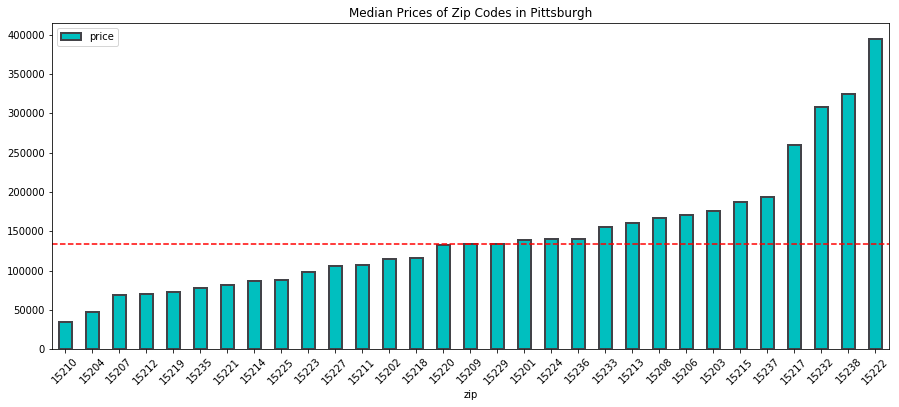

In [34]:
#graph of mean price by zip codes in pittsburgh
plt.figure(figsize=(15,6))
zip_median = zip_median.sort_values(by='price')
zip_median[['zip', 'price']].plot(
    x='zip', 
    y='price', 
    ax = plt.gca(), 
    kind='bar', 
    color='c',
    edgecolor='#434348',
    linewidth=2
)
plt.axhline(zip_median['price'].median(), color='r', linestyle='--')
plt.xticks(rotation=45)
plt.title('Median Prices of Zip Codes in Pittsburgh')
plt.show()

### Visualiztion and Analysis: Median Price Over Time
#### Splitting the sale date

The original sale date is formatted as "yyy-mm-dd". These values are split out into one year column, one month column, and one day column for an analysis of home price over time.

In [35]:
def split_year(input_value):
    return input_value[:4]

def split_month(input_value):
    return input_value[5:7]
    
def split_day(input_value):
    return input_value[8:10]
pgh_city_df = pgh_city_df.assign(sale_year=pgh_city_df.sale_date.apply(split_year))
pgh_city_df = pgh_city_df.assign(sale_month=pgh_city_df.sale_date.apply(split_month))
pgh_city_df = pgh_city_df.assign(sale_day=pgh_city_df.sale_date.apply(split_day))

In [36]:
year_median = pgh_city_df.groupby('sale_year', as_index=False).agg({"price": "median"})
year_median.head()

,sale_year,price
0,2012,"$112,500.00"
1,2013,"$127,509.00"
2,2014,"$118,000.00"
3,2015,"$129,788.50"
4,2016,"$131,000.00"


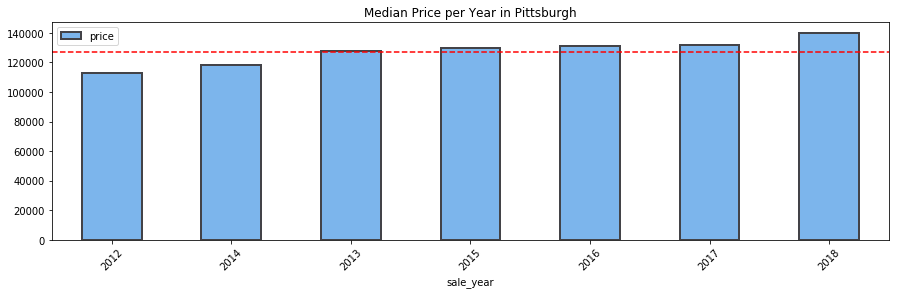

In [37]:
#graph of mean price by zip codes in pittsburgh
plt.figure(figsize=(15, 4))
year_median = year_median.sort_values(by='price')
year_median[['sale_year', 'price']].plot(
    x='sale_year', 
    y='price', 
    ax = plt.gca(), 
    kind='bar', 
    color='#7cb5ec',
    edgecolor='#434348',
    linewidth=2
)
plt.axhline(year_median['price'].mean(), color='r', linestyle='--')
plt.xticks(rotation=45)
plt.title('Median Price per Year in Pittsburgh')
plt.show()

In [38]:
month_median = pgh_city_df.groupby('sale_month', as_index=False).agg({"price": "median"})

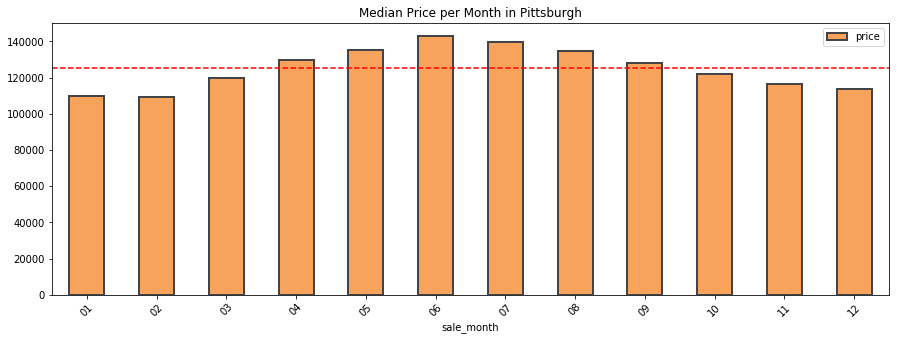

In [39]:
plt.figure(figsize=(15, 5))
month_median = month_median.sort_values(by='sale_month')
month_median[['sale_month', 'price']].plot(
    x='sale_month', 
    y='price', 
    ax = plt.gca(), 
    kind='bar', 
    color='#f7a35c',
    edgecolor='#434348',
    linewidth=2
)
plt.axhline(month_median['price'].mean(), color='r', linestyle='--')
plt.xticks(rotation=45)
plt.title('Median Price per Month in Pittsburgh')
plt.show()

### Visualization and Analysis: Foreclosures
#### Have foreclosures risen or fallen over the years

Foreclosures put pressure on the real estate market. Banks have to pay taxes on the properties they own. As banks hold foreclosed properties over time they lower the prices on those properties. If they can get rid of a property for a loss that is lower than their tax burden on the property, they will. The more foreclosures on the market, the lower prices in the surrounding area drop.

In [40]:
foreclosed_year = pgh_city_df.groupby('sale_year', as_index=False).agg({"foreclosed": "sum"})
foreclosed_year = foreclosed_year.assign(foreclosed=foreclosed_year.foreclosed.astype(int))
foreclosed_year.head()

,sale_year,foreclosed
0,2012,201
1,2013,518
2,2014,650
3,2015,628
4,2016,779


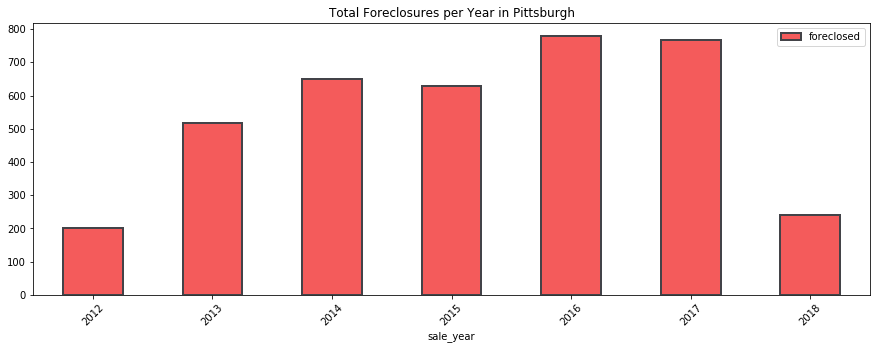

In [41]:
#graph of mean price by zip codes in pittsburgh
plt.figure(figsize=(15, 5))
foreclosed_year = foreclosed_year.sort_values(by='sale_year')
foreclosed_year[['sale_year', 'foreclosed']].plot(
    x='sale_year', 
    y='foreclosed', 
    ax=plt.gca(), 
    kind='bar', 
    color='#f45b5b',
    edgecolor='#434348',
    linewidth=2
)
plt.xticks(rotation=45)
plt.title('Total Foreclosures per Year in Pittsburgh')
plt.show()

### Visualization and Analysis: Log Price

The median price on homes in Pittsburgh is hard to visualize in a boxplot because there's not a lot of dissimilarity. Converting the price to the logarithm of that price keeps relative values, but reveals the span of prices.

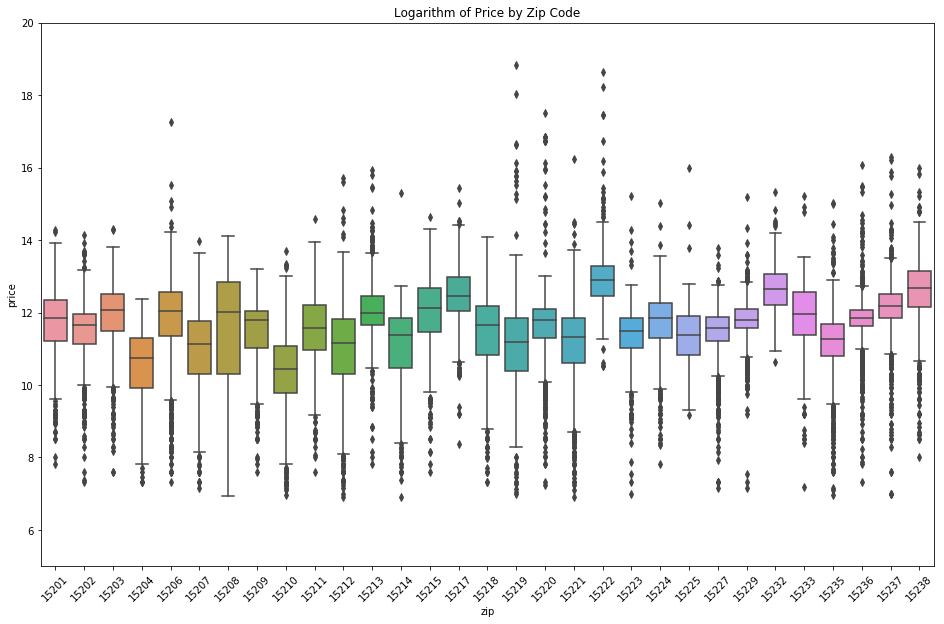

In [42]:
f, ax = plt.subplots(figsize=(16, 10))
log_price = np.log(pgh_city_df.price)
log_price_year = log_price.to_frame().join(pgh_city_df.zip)
fig = sns.boxplot(x="zip", y="price", data=log_price_year)
fig.axis(ymin=5, ymax=20);
xt = plt.xticks(rotation=45)
plt.title('Logarithm of Price by Zip Code')
plt.show()

## Comparing Home Prices to Demographics
### Population and Income

The demand on the real estate market is determined by local incomes and population. Real estate prices are driven up by population growth and rising income. As more people flood to an area or as incomes on the existing population rise, real estate prices rise to meet demand.

In [43]:
pd.options.display.float_format = '{:.2f}'.format
raw_zip_income = pd.read_csv('data/ACS_16_5YR_S1903_with_ann.csv')
temp = raw_zip_income[['GEO.display-label', 'HC01_EST_VC02', 'HC02_EST_VC02']]
temp.columns = ['zip', 'pop', 'median_income']
temp.zip = temp.zip.str.replace('ZCTA5 ', '', regex=False)
pgh_income_price = pd.merge(temp, pgh_city_df)
pgh_income_price.head()

,zip,pop,median_income,street_address,city,state,sale_date,price,sale_code,foreclosed,sale_year,sale_month,sale_day
0,15201,6121,51201,246 38TH ST,PITTSBURGH,PA,2015-07-23,125000.00,36,False,2015,07,23
1,15201,6121,51201,1357 HAWTHORNE ST,PITTSBURGH,PA,2015-07-21,139000.00,36,False,2015,07,21
2,15201,6121,51201,4217 BRUCE ST,PITTSBURGH,PA,2015-07-21,279000.00,36,False,2015,07,21
3,15201,6121,51201,4814 HATFIELD ST,PITTSBURGH,PA,2015-07-31,234500.00,36,False,2015,07,31
4,15201,6121,51201,175 45TH ST,PITTSBURGH,PA,2015-07-31,162000.00,36,False,2015,07,31


In [44]:
pgh_income_price.isna().sum()

zip               0
pop               0
median_income     0
street_address    0
city              0
state             0
sale_date         0
price             0
sale_code         0
foreclosed        0
sale_year         0
sale_month        0
sale_day          0
dtype: int64

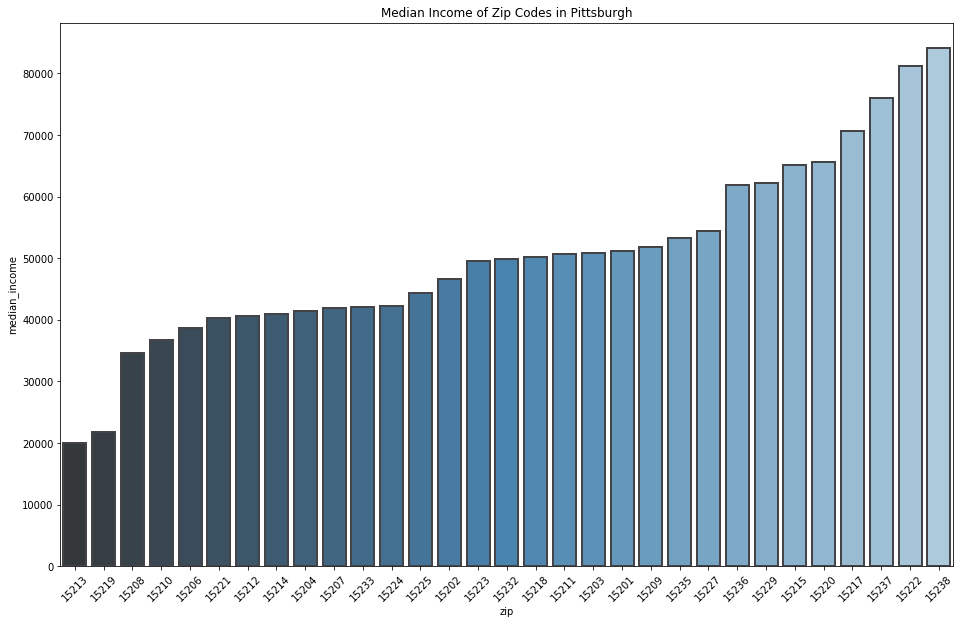

In [45]:
plt.figure(figsize=(16, 10))
pgh_income_price.median_income = pgh_income_price.median_income.astype(float)
result = pgh_income_price[['zip', 'median_income']].drop_duplicates('zip').sort_values(['median_income'])
ax = sns.barplot(
    result.zip, 
    result.median_income, 
    order=result['zip'], 
    palette="Blues_d",
    edgecolor='#434348',
    linewidth=2
)
plt.xticks(rotation=45)
plt.title('Median Income of Zip Codes in Pittsburgh')
plt.show()

In [46]:
raw_pop = pd.read_csv('data/PEP_2017_PEPANNRES.csv')

In [47]:
columns = ['respop72010', 'respop72011', 'respop72012', 'respop72013', 'respop72014', 'respop72015', 'respop72016', 'respop72017']
pgh_pop = {}
for k, v in raw_pop.to_dict().items():
    if k in columns:
        pgh_pop[k[-4:]] = v[0]
    
pgh_pop = pd.DataFrame.from_dict(pgh_pop, orient='index', columns=['pop']).reset_index()
pgh_pop.columns = ['year', 'pop']

### Population to Median Real Estate Price
Comparing median real estate price to population. Starting in 2012, normalizing the value of population and real estate median price will show if population has kept pace with rising prices. To normalize the values, each year's population was subtracted from the 2012 population. For example, 2012 population is 306469, 2013 population is 306181. The normalized populations are 0 for 2012 and -288 for 2013.

The same is done for price. For example, 2012's median price is 112,500, 2013 median price is 118,000. The normalized median prices are 0 for 2012 and + 5,500 for 2013.

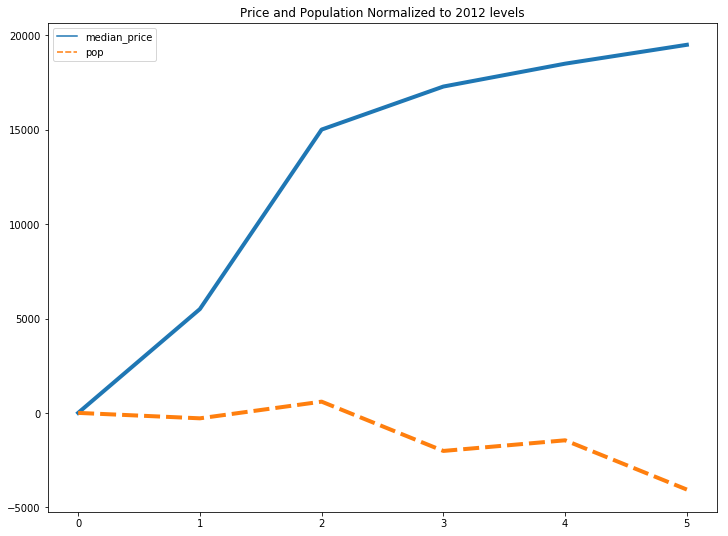

In [48]:
plt.figure(figsize=(12, 9))
year_median.columns = [
    'year',
    'median_price'
]
pgh_pop_price = pd.merge(year_median, pgh_pop)
pgh_pop_price.sort_values('year')
pgh_pop_price = pgh_pop_price[['median_price', 'pop']]
normed = pgh_pop_price.rolling(1).mean()
normed['median_price'] = normed['median_price'] - pgh_pop_price['median_price'][0]
normed['pop'] = normed['pop'] - pgh_pop_price['pop'][0]
sns.lineplot(data=normed, palette="tab10", linewidth=4)
plt.title('Price and Population Normalized to 2012 levels')
plt.show()

### Income to Median Real Estate Price

The same normalization strategy is used for income levels. Income levels are normalized to 2012 at 0.

In [49]:
income_raw = pd.read_csv('data/PITT342PCPI.csv', names=['year', 'income'], header=43)
income_raw.year = income_raw.year.apply(lambda x: x[:4])

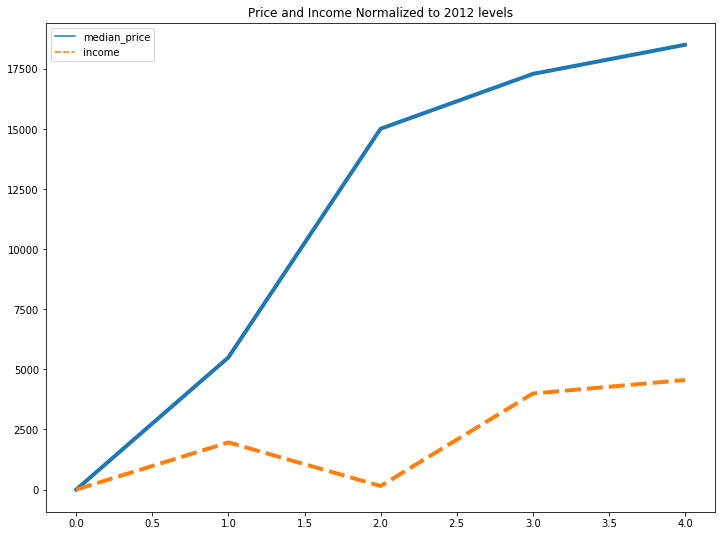

In [50]:
plt.figure(figsize=(12, 9))
income_price = pd.merge(year_median, income_raw)
income_price.sort_values('year')
income_price = income_price[['median_price', 'income']]
normed = income_price.rolling(1).mean()
normed['median_price'] = normed['median_price'] - income_price['median_price'][0]
normed['income'] = normed['income'] - income_price['income'][0]
sns.lineplot(data=normed, palette="tab10", linewidth=4)
plt.title('Price and Income Normalized to 2012 levels')
plt.show()